In [1]:
import os, gzip
import matplotlib.pyplot as plt
import pysam

import sys

sys.path.append("../../../src/")
import lakeview as lv

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 100

## Download BAM files

In [3]:
CHROMOSOME = "chr14"
START = 104586347
END = 107043718
REGION = f"{CHROMOSOME}:{START}-{END}"


PACBIO_BAM_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam"
PACBIO_BAI_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam.bai"
PACBIO_BAM_PATH = "data/PacBio_CCS.bam"
PACBIO_BAI_PATH = "data/PacBio_CCS.bam.bai"

if not os.path.isfile(PACBIO_BAM_PATH):
    os.makedirs("data", exist_ok=True)
    bam_data = pysam.view(
        "-X",
        "-b",
        PACBIO_BAM_URL,
        PACBIO_BAI_URL,
        REGION,
    )
    !rm -f *.bam.bai
    with open(PACBIO_BAM_PATH, "wb") as f:
        f.write(bam_data)
if not os.path.isfile(PACBIO_BAI_PATH):
    pysam.index(PACBIO_BAM_PATH)

## Download GTF file

In [6]:
GENCODE_GTF_URL = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz"
GENCODE_GTF_PATH = "data/gencode.v40.annotation.gtf.gz"
if not os.path.isfile(GENCODE_GTF_PATH):
    !wget {GENCODE_GTF_URL} -O {GENCODE_GTF_PATH}


## Load data

In [7]:
pacbio_painter = lv.SequenceAlignment.from_file(PACBIO_BAM_PATH, "rb")

In [8]:
with gzip.open(GENCODE_GTF_PATH, "rt") as f:
    gencode_painter = lv.GeneAnnotation.from_file(
        file_handle=f,
        format="gtf",
        sequence_name=CHROMOSOME,
        start=START,
        end=END,
    )
gencode_painter.transcripts.sort(key=len, reverse=True)

## Plotting

In [13]:
plt.ioff()
gv = lv.GenomeViewer(3, height_ratios=(1, 8, 2))
pacbio_painter.draw_pileup(
    gv.axes[0],
    show_mismatches=False,
)
pacbio_painter.draw_alignment(
    gv.axes[1],
    show_mismatches=False,
    order=lambda seg: -seg.query_alignment_length,
    max_depth=50,
)
gencode_painter.draw_transcripts(gv.axes[2], max_group_depth=4, labels=lambda t: t.id)

gv.set_xlim((105679000, 105776000))

In [14]:
gv

AppLayout(children=(VBox(children=(HBox(children=(Text(value='105,679,000 - 105,776,000', placeholder=''), But…

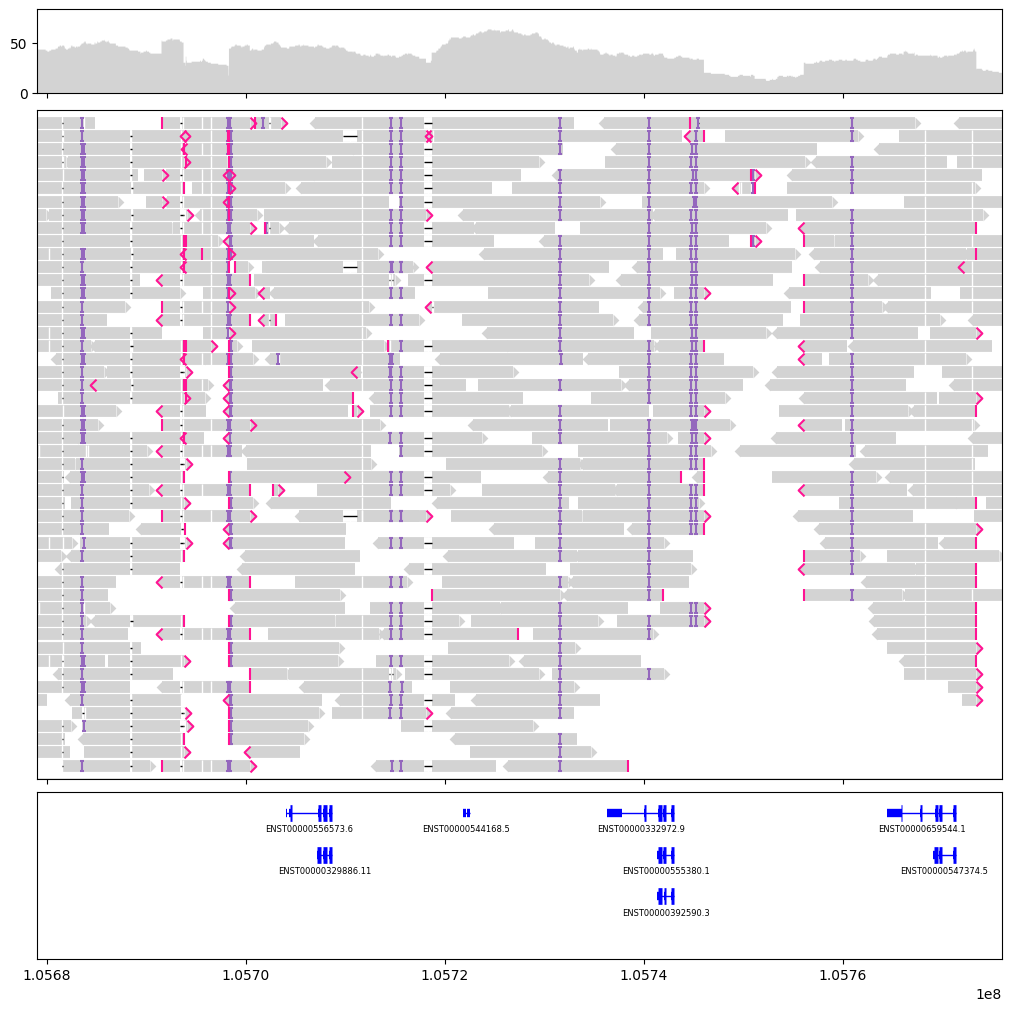

In [15]:
gv.figure